In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# load parquet files
import pandas as pd

df_train = pd.read_parquet("../data/train_1000_with_embeddings.parquet")
df_val = pd.read_parquet("../data/val_100_with_embeddings.parquet")
df_test = pd.read_parquet("../data/test_100_with_embeddings.parquet")

In [2]:
import pandas as pd
import numpy as np
from notebooks.eagle_old_version import EagleRouter

In [ ]:
# Grid search for hyperparameter optimization
import itertools
from tqdm import tqdm

# Define hyperparameter search space
P_values = [
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1,
]  # Weight for global vs local scores
N_values = [
    5,
    10,
    20,
    30,
    50,
]  # Number of nearest neighbors
K_values = [
    1,
    2,
    4, 
    8,
    16,
    32, 
    64,
]  # ELO sensitivity

# Store results
results = []
elo_scores = []

print("Starting hyperparameter optimization...")
print(f"Total combinations to test: {len(P_values) * len(N_values) * len(K_values)}")

# Grid search
for P, N, K in tqdm(
    itertools.product(P_values, N_values, K_values),
    total=len(P_values) * len(N_values) * len(K_values),
    desc="Grid Search",
):
    # Initialize router with current hyperparameters
    router = EagleRouter(P=P, N=N, K=K)

    # Train global scores
    router.train_global_scores()

    # Save elo scores
    elo_scores.append(
        {
            "p": P,
            "n": N,
            "k": K,
            "scores": router.global_scores,
            "models": list(router.global_scores.keys()),
        }
    )

    # Evaluate on validation set
    correct = 0
    tied_case_score = 0
    tied_case_count = 0
    for i in range(len(df_val)):
        row = df_val.iloc[i]
        query_prompt_embedding = row["prompt_embedding"]
        gold_model = (
            "gpt-4o-2024-08-06"
            if row["gpt-4o-2024-08-06/score"] > row["gpt-4o-mini-2024-07-18/score"]
            else "gpt-4o-mini-2024-07-18"
        )
        if row["gpt-4o-2024-08-06/score"] == row["gpt-4o-mini-2024-07-18/score"]:
            gold_model = None
            tied_case_count += 1
        
        result_dict = router.route(query_prompt_embedding)
        chsen_model_name = max(result_dict, key=result_dict.get)
        if gold_model is None:
            elo_a, elo_b = result_dict.values()
            abs_elo_diff = abs(elo_a - elo_b)
            TIED_CASE_SCORE_PENALTY_SCALE = 30 # Need to adjust this parameter
            score = 1 - abs_elo_diff / TIED_CASE_SCORE_PENALTY_SCALE
            tied_case_score += max(score, 0)
        if chsen_model_name == gold_model:
            correct += 1

    accuracy = correct / (len(df_val) - tied_case_count)
    tied_case_accuracy = tied_case_score / tied_case_count

    # Store results
    results.append({"P": P, "N": N, "K": K, "accuracy": accuracy, "tied_case_accuracy": tied_case_accuracy})


Starting hyperparameter optimization...
Total combinations to test: 385


Grid Search: 100%|██████████| 385/385 [00:43<00:00,  8.95it/s]


In [4]:
# save result to json
import json
with open("elo_scores.json", "w") as f:
    json.dump(elo_scores, f)

In [5]:

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("accuracy", ascending=False)

print("\n" + "=" * 50)
print("Sorted Hyperparameter Combinations:")
print("=" * 50)
print(results_df.to_string(index=False))

# Find best hyperparameters
best_params = results_df.iloc[0]
print("\n" + "=" * 50)
print("Best Hyperparameters Found:")
print(f"P = {best_params['P']}")
print(f"N = {best_params['N']}")
print(f"K = {best_params['K']}")
print(f"Validation Accuracy = {best_params['accuracy']:.4f}")
print("=" * 50)


Sorted Hyperparameter Combinations:
  P  N  K  accuracy  tied_case_accuracy
0.3 20 32  0.681818            0.040012
0.2 50 16  0.681818            0.089420
0.3 10 64  0.681818            0.041299
0.3 50 32  0.681818            0.100024
0.0 50  8  0.681818            0.129987
0.4 20 64  0.681818            0.036742
0.3 20 64  0.681818            0.036761
0.0 30  8  0.666667            0.085411
0.0 30 16  0.666667            0.076404
0.3 30 32  0.666667            0.029192
0.1 20  8  0.666667            0.117526
0.1 20  2  0.666667            0.419369
0.0 50 16  0.666667            0.128328
0.0 30  1  0.666667            0.732464
0.2 20 16  0.666667            0.047311
0.2 20  8  0.666667            0.073336
0.1 10 32  0.666667            0.090699
0.2 10 64  0.666667            0.036184
0.2 10 32  0.666667            0.065283
0.1 10 16  0.666667            0.136669
0.0 30  4  0.666667            0.194930
0.0 30  2  0.666667            0.488771
0.5 20 64  0.666667            0.000000
0.2

In [6]:
stop

NameError: name 'stop' is not defined

In [ ]:
import pandas as pd

# Load your precomputed embeddings parquet file
df_test = pd.read_parquet("../data/test_100.parquet")

# Evaluate best model on test set

print("Evaluating Best Model on Test Set\n")

print("WITH DEFAULT PARAMETERS")
default_router = EagleRouter()
default_router.train_global_scores()

# Evaluate on test set
test_correct = 0
for i in range(len(df_test)):
    row = df_test.iloc[i]
    query_prompt_embedding = row["prompt_embedding"]
    gold_model = (
        "gpt-4o-2024-08-06"
        if row["gpt-4o-2024-08-06/score"] > row["gpt-4o-mini-2024-07-18/score"]
        else "gpt-4o-mini-2024-07-18"
    )
    chosen_model = default_router.route(query_prompt_embedding)
    if chosen_model == gold_model:
        test_correct += 1

test_accuracy = test_correct / len(df_test)

print(f"Test Set Accuracy with default parameters: {test_accuracy:.4f}")

print("="*50)
print("WITH BEST PARAMETERS\n\n")
# Create router with best hyperparameters
best_router = EagleRouter(
    P=0.0001, 
    # P=best_params['P'], 
    N=int(best_params['N']), 
    K=int(best_params['K'])
)
best_router.train_global_scores()

# Evaluate on test set
test_correct = 0
for i in range(len(df_test)):
    row = df_test.iloc[i]
    format_prompt = f"""
Q. {row["question"]}
A. {row["gold_answer"]}

4o: {row["gpt-4o-2024-08-06/response"]}
mini: {row["gpt-4o-mini-2024-07-18/response"]}
"""
    query_prompt_embedding = row["prompt_embedding"]
    gold_model = (
        "gpt-4o-2024-08-06"
        if row["gpt-4o-2024-08-06/score"] > row["gpt-4o-mini-2024-07-18/score"]
        else "gpt-4o-mini-2024-07-18"
    )
    chosen_model = best_router.route(query_prompt_embedding)
    if chosen_model == gold_model:
        test_correct += 1
    else:
        print(f"4o:{row["gpt-4o-2024-08-06/score"]}, mini:{row["gpt-4o-mini-2024-07-18/score"]}\nPrompt: {format_prompt}\n\n")

test_accuracy = test_correct / len(df_test)

print(f"Test Set Accuracy with best parameters: {test_accuracy:.4f}")


Evaluating Best Model on Test Set

WITH DEFAULT PARAMETERS
Test Set Accuracy with default parameters: 0.9500
WITH BEST PARAMETERS


4o:1, mini:0
Prompt: 
Q. What challenge did cybersecurity expert Michael Henderson identify regarding the adoption of post-quantum cryptography?
A. The challenge of integrating new standards into existing systems worldwide.

4o: Integration presents a significant hurdle.
mini: Current systems worldwide need to be examined and overhauled to accommodate new standards.



4o:1, mini:0
Prompt: 
Q. What new tool did Compliance.AI launch for SMEs, and how does it help businesses?
A. Compliance.AI launched an SME-focused tool in May 2024 that helps businesses monitor and adhere to regulatory requirements.

4o: Compliance.AI launched a new SME-focused tool in May 2024 that helps businesses monitor and adhere to regulatory requirements.
mini: Compliance.AI launched a tool focused on SMEs that helps businesses monitor and adhere to regulatory requirements.



4o:1, 

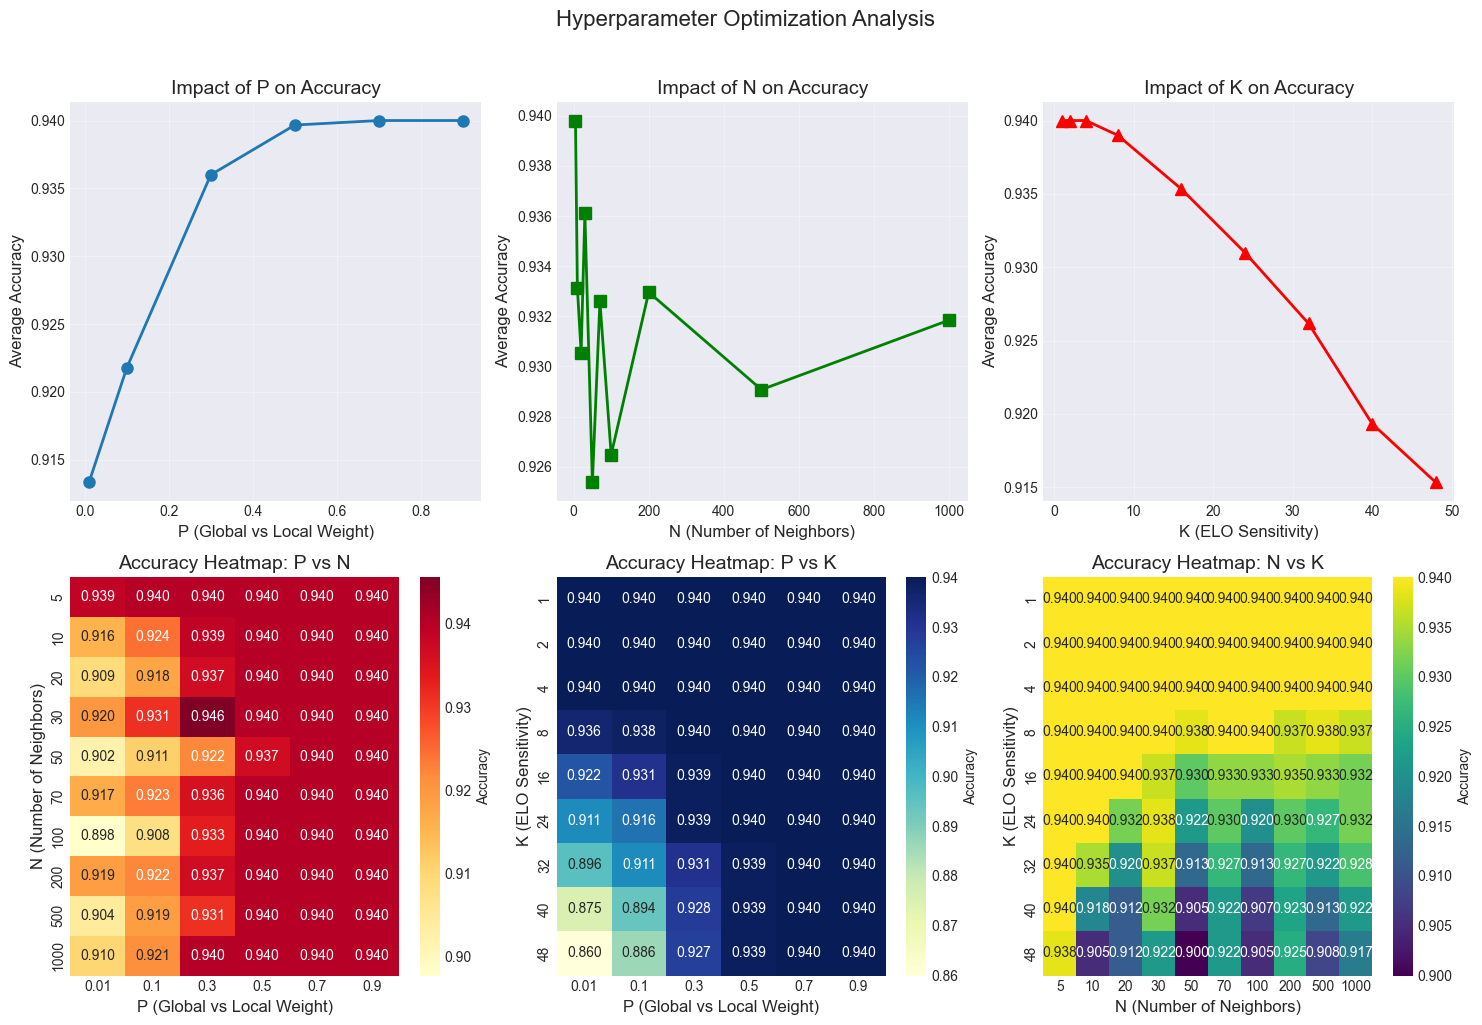

In [ ]:
# Visualize hyperparameter optimization results
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Average accuracy by P value
p_avg = results_df.groupby('P')['accuracy'].mean().reset_index()
axes[0, 0].plot(p_avg['P'], p_avg['accuracy'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('P (Global vs Local Weight)', fontsize=12)
axes[0, 0].set_ylabel('Average Accuracy', fontsize=12)
axes[0, 0].set_title('Impact of P on Accuracy', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# 2. Average accuracy by N value
n_avg = results_df.groupby('N')['accuracy'].mean().reset_index()
axes[0, 1].plot(n_avg['N'], n_avg['accuracy'], marker='s', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('N (Number of Neighbors)', fontsize=12)
axes[0, 1].set_ylabel('Average Accuracy', fontsize=12)
axes[0, 1].set_title('Impact of N on Accuracy', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# 3. Average accuracy by K value
k_avg = results_df.groupby('K')['accuracy'].mean().reset_index()
axes[0, 2].plot(k_avg['K'], k_avg['accuracy'], marker='^', linewidth=2, markersize=8, color='red')
axes[0, 2].set_xlabel('K (ELO Sensitivity)', fontsize=12)
axes[0, 2].set_ylabel('Average Accuracy', fontsize=12)
axes[0, 2].set_title('Impact of K on Accuracy', fontsize=14)
axes[0, 2].grid(True, alpha=0.3)

# 4. Heatmap for P vs N (averaged over K)
pn_pivot = results_df.pivot_table(values='accuracy', index='N', columns='P', aggfunc='mean')
sns.heatmap(pn_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Accuracy'})
axes[1, 0].set_xlabel('P (Global vs Local Weight)', fontsize=12)
axes[1, 0].set_ylabel('N (Number of Neighbors)', fontsize=12)
axes[1, 0].set_title('Accuracy Heatmap: P vs N', fontsize=14)

# 5. Heatmap for P vs K (averaged over N)
pk_pivot = results_df.pivot_table(values='accuracy', index='K', columns='P', aggfunc='mean')
sns.heatmap(pk_pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[1, 1], cbar_kws={'label': 'Accuracy'})
axes[1, 1].set_xlabel('P (Global vs Local Weight)', fontsize=12)
axes[1, 1].set_ylabel('K (ELO Sensitivity)', fontsize=12)
axes[1, 1].set_title('Accuracy Heatmap: P vs K', fontsize=14)

# 6. Heatmap for N vs K (averaged over P)
nk_pivot = results_df.pivot_table(values='accuracy', index='K', columns='N', aggfunc='mean')
sns.heatmap(nk_pivot, annot=True, fmt='.3f', cmap='viridis', ax=axes[1, 2], cbar_kws={'label': 'Accuracy'})
axes[1, 2].set_xlabel('N (Number of Neighbors)', fontsize=12)
axes[1, 2].set_ylabel('K (ELO Sensitivity)', fontsize=12)
axes[1, 2].set_title('Accuracy Heatmap: N vs K', fontsize=14)

plt.suptitle('Hyperparameter Optimization Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
